In [1]:
# Standar Library
import gym, os
import numpy as np

# Standar Game
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

# Warnings
import warnings
warnings.filterwarnings('ignore')

Setup The Environment

In [2]:
env = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode='human')
env = JoypadSpace(env, COMPLEX_MOVEMENT)
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)


In [8]:
episodes = 2

for episode in range(episodes):
    observation, _ = env.reset()
    done = False
    score = 0

    while not done:
        env.render()
        action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        score += reward
        done = terminated or truncated

    print(f'episode = {episode}, score = {score}')

episode = 0, score = -5.0
episode = 1, score = -31.0


In [3]:
done = True
for step in range(10000):
    if done:
        env.reset()
    state, reward, truncate, terminated, info = env.step(env.action_space.sample())
    done = terminated or truncate
    env.render()

# env.close()

Preprocessing The Environment

In [2]:
from gym.wrappers import GrayScaleObservation, FrameStack
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, SubprocVecEnv
import matplotlib.pyplot as plt
from stable_baselines3.common.env_util import make_vec_env

In [3]:
env = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode='rgb_array')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)

In [4]:
# Grayscale The Environment Tanpa Stack
# env = GrayScaleObservation(env, keep_dim=True)
# env = DummyVecEnv([lambda:env])

# Grayscale The Environment Dengan Stack
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda:env])
env = VecFrameStack(env, n_stack=4, channels_order='last')

In [9]:
env.reset().shape

(1, 240, 256, 4)

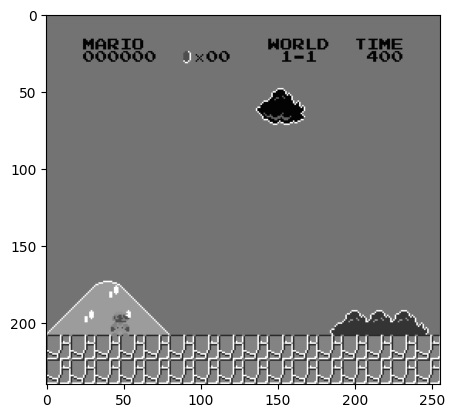

In [18]:
plt.imshow(env.reset()[0])

In [79]:
state = env.reset()

In [85]:
state, reward, done, info = env.step([env.action_space.sample()])

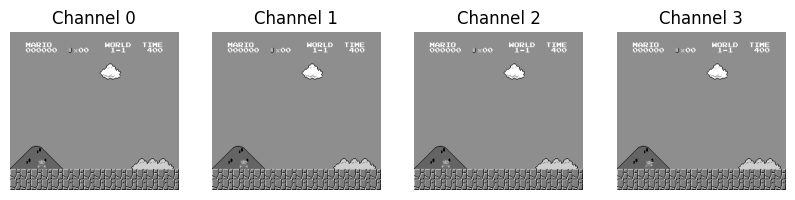

In [86]:
plt.figure(figsize=(10, 8))
for index in range(state.shape[3]):
    plt.subplot(1, 4, index + 1)
    plt.imshow(state[0, :, :, index], cmap='gray')  # Menggunakan 'gray' colormap untuk gambar grayscale
    plt.title(f'Channel {index}')
    plt.axis('off')
plt.show()

Make The Model

In [5]:
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.callbacks import BaseCallback, StopTrainingOnRewardThreshold, EvalCallback

path_logs = 'D:/Source Code/Python/RL_model/training/logs'
model = PPO(
    'CnnPolicy',
    env,
    verbose=1,
    learning_rate=0.0001,
    tensorboard_log=path_logs,
    n_steps=1024
)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [ ]:
stop_train = StopTrainingOnRewardThreshold(reward_threshold=800, verbose=1)
eval_callback = EvalCallback(
    env, 
    stop_train,
    eval_freq=1000,
    n_eval_episodes=5, 
    best_model_save_path= 'D:/Source Code/Python/RL_model/training/model_saved',
    verbose=1
)

In [6]:
model.learn(
    total_timesteps=10000
)

Logging to D:/Source Code/Python/RL_model/training/logs\PPO_6
-----------------------------
| time/              |      |
|    fps             | 46   |
|    iterations      | 1    |
|    time_elapsed    | 22   |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 8           |
|    iterations           | 2           |
|    time_elapsed         | 254         |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.010777916 |
|    clip_fraction        | 0.0971      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.00237    |
|    learning_rate        | 0.0001      |
|    loss                 | 8.98        |
|    n_updates            | 10          |
|    policy_gradient_loss | 0.000731    |
|    value_loss           | 73          |
--------------

Test The Model

In [10]:
episodes = 1

for episode in range(episodes):
    obs = env.reset()
    done = False
    score = 0

    while not done:
        env.render()
        action, _state = model.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
    
    print(f'Episode = {episode}, Total Score = {score}')

Episode = 0, Total Score = [641.]


In [11]:
model.save('D:/Source Code/Python/RL_model/training/model_saved')

In [13]:
from stable_baselines3.common.evaluation import evaluate_policy

evaluate_policy(model, env, render=True)

(680.0, 0.0)